In [2]:
from astroquery.utils.tap.core import TapPlus
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('..')

from astroLuSt.database_interface import alerceinterface as aldiai
from astroLuSt.database_interface import database_utils as aldidu
from astroLuSt.database_interface import eleanorinterface as aldiei
from astroLuSt.database_interface import gaiainterface as aldigi
from astroLuSt.database_interface import lightkurveinterface as aldili
from astroLuSt.database_interface import simbadinterface as aldisi

import importlib
importlib.reload(aldiai)
importlib.reload(aldidu)
importlib.reload(aldiei)
importlib.reload(aldigi)
importlib.reload(aldili)
importlib.reload(aldisi)

#style for plotting
plt.style.use('astroLuSt.styles.LuSt_style')



In [9]:
targets = [
    'KIC 5006817', 'RR Lyr', 'TV Boo', 'KIC 5006817',
    'TIC 100015323' #nSot listed in Simbad
]

# SimbadDatabaseInterface
* Use [`pd.Series.str.extractall()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.extractall.html#pandas.Series.str.extractall) to extract relevant ids

In [59]:
importlib.reload(aldisi)

SDI = aldisi.SimbadDatabaseInterface(
    npartitions=3, n_jobs=1, simbad_timeout=120,
    verbose=3
)

df_ids = SDI.get_ids(
    input_ids=targets,
    npartitions=None,
    n_jobs=None,
    simbad_timeout=None,
    verbose=None,
    parallel_kwargs=None,
    query_tap_kwargs=None,
)
display(df_ids)


#extract relevant IDs
df_ids_sep = df_ids['ids'].str.extractall(pat=(
    r'(?P<id_gaiadr3>Gaia DR3[^|\n]+)'
    r'|(?P<id_gaiadr2>Gaia DR2[^|\n]+)'
    r'|(?P<id_apogee>AP[^|\n]+)'
    r'|(?P<id_tic>TIC[^|\n]+)'
)).groupby(level=0).first()

display(df_ids_sep)

INFO(): Working on parition 1/3
INFO(): Working on parition 2/3
INFO(): Working on parition 3/3


,input_id,main_id,ids,ra,dec
0,KIC 5006817,KIC 5006817,AP J19214942+4008446|Gaia DR3 2101103743584479...,290.455967,40.145732
1,RR Lyr,V* RR Lyr,HIP 95497|AP J19252793+4247040|Gaia DR3 212598...,291.366304,42.784359
2,TV Boo,V* TV Boo,HIP 69759|AP J14163658+4221356|Gaia DR3 149223...,214.152423,42.359920
3,KIC 5006817,KIC 5006817,AP J19214942+4008446|Gaia DR3 2101103743584479...,290.455967,40.145732
4,TIC 100015323,,,NaN,NaN


,id_gaiadr3,id_gaiadr2,id_apogee,id_tic
0,Gaia DR3 2101103743584479744,Gaia DR2 2101103739284386688,AP J19214942+4008446,TIC 122447138
1,Gaia DR3 2125982599343482624,Gaia DR2 2125982599341232896,AP J19252793+4247040,TIC 159717514
2,Gaia DR3 1492230556717187456,Gaia DR2 1492230556717187456,AP J14163658+4221356,TIC 168709463
3,Gaia DR3 2101103743584479744,Gaia DR2 2101103739284386688,AP J19214942+4008446,TIC 122447138


In [59]:
# #DEPRECATED

# importlib.reload(aldisi)

# SDI = aldisi.SimbadDatabaseInterface(
#     simbad_timeout=120,
#     npartitions=1,
#     verbose=3,
# )
# print(SDI)
# df_ids = SDI.extract_ids(
#     input_ids=targets,
#     show_scanned_strings_at=[1],
#     verbose=None,
#     parallel_kwargs=dict(n_jobs=4),
# )

# tics = df_ids['TIC']
# print(tics)

# df_ids

# EleanorDatabaseInterface

In [60]:
importlib.reload(aldiei)

EDI = aldiei.EleanorDatabaseInterface(
    n_jobs=2,
    redownload=True,
    verbose=3,
)

lcs, metas, tpfs, aperture_masks = EDI.download(
    # sectors=[14],
    sectors='all',
    # source_ids=[{'tic':tic} for tic in tics[:]],
    source_ids=[{'tic':'234507163'}],
    # source_ids=[{'gaia': '2249474965068982272'}],
    # source_ids=[{'gaia': '2249474965068982272'}, {'gaia': '114797397716085120'}],
    get_normalized_flux=True, normfunc=lambda x, datum: x/np.nanmedian(x[datum.quality == 0]),
    tpfs2store=slice(1), store_aperture_masks=True,
    # tpfs2store=None, store_aperture_masks=True,
    n_chunks=1,
    # targetdata_kwargs=dict(do_pca=True, aperture_mode='small'),
    targetdata_kwargs=dict(do_pca=True),
    # custom_aperture_kwargs=dict(shape='rectangle', h=3, w=4), #in case you want to use a custom aperture
    # save_kwargs=dict(directory='./data/', pd_savefunc='to_parquet', store_metadata=True),
    save_kwargs=dict(directory=None, pd_savefunc='to_parquet', store_metadata=True),
)

fig, axs = EDI.plot_result(
    lcs=lcs[0],
    tpfs=tpfs[0],
    aperture_masks=aperture_masks[0],
)

plt.show()

pd.DataFrame(metas[0])

INFO(EleanorDatabaseInterface.download()): Extracting chunk 1/1 (1/1)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


# GaiaDatabaseInterface

/home/lukas/venvs/astroLuSt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


dict_keys(['EPOCH_PHOTOMETRY-Gaia DR3 2125982599343482624.xml', 'EPOCH_PHOTOMETRY-Gaia DR3 1492230556717187456.xml', 'MCMC_GSPPHOT-Gaia DR3 2125982599343482624.xml'])
Index(['source_id', 'transit_id', 'band', 'time', 'mag', 'flux', 'flux_error',
       'flux_over_error', 'rejected_by_photometry', 'rejected_by_variability',
       'other_flags', 'solution_id', 'flux_normalized'],
      dtype='object')
band
G     40
BP    39
RP    39
Name: count, dtype: int64
1.0


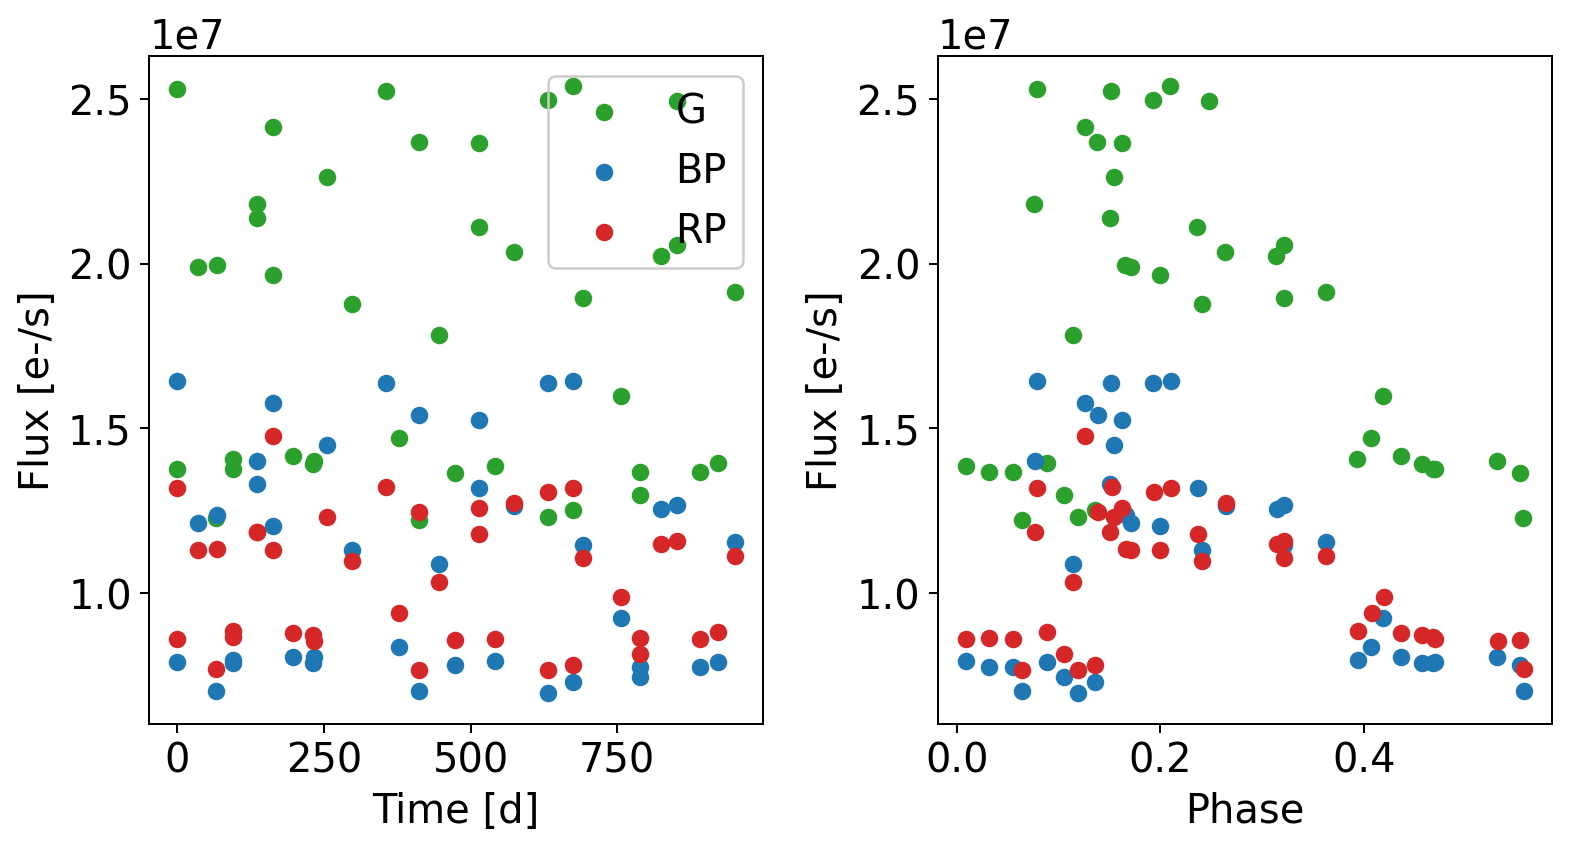

In [ ]:
importlib.reload(aldigi)

GDI = aldigi.GaiaDatabaseInterface(
    gaia_class=Gaia,
    verbose=0
)


# filter = "(jobs['phase'] == 'ERROR')"
# GDI.remove_all_jobs(pd_filter=filter, login_before=False, logout_after=False)


# print(df_ids.keys)
res = GDI.get_datalink(
    ids=df_ids['Gaia DR3'],
    normfunc=lambda x, df: x/np.nanmedian(x),
    retrieval_type=['EPOCH_PHOTOMETRY','MCMC_GSPPHOT'],
    # retrieval_type=['ALL'],
    n_chunks=2,
    load_data_kwargs=dict(
        data_release='Gaia DR3',
    ),
    save_kwargs=dict(directory='./data/')
)



df = res[list(res.keys())[0]]
print(res.keys())

print(df.columns)


print(df['band'].value_counts())

df['phase'] = df['time']%0.56666
df['time'] -= df['time'].min()

print(df.query('band=="G"')['flux_normalized'].median())

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(*df.query('band=="G"')[[ 'time', 'flux']].values.T, c='tab:green', label='G')
ax1.scatter(*df.query('band=="BP"')[['time', 'flux']].values.T, c='tab:blue',  label='BP')
ax1.scatter(*df.query('band=="RP"')[['time', 'flux']].values.T, c='tab:red',   label='RP')
ax2.scatter(*df.query('band=="G"')[[ 'phase','flux']].values.T, c='tab:green', label='G')
ax2.scatter(*df.query('band=="BP"')[['phase','flux']].values.T, c='tab:blue',  label='BP')
ax2.scatter(*df.query('band=="RP"')[['phase','flux']].values.T, c='tab:red',   label='RP')

ax1.set_xlabel('Time [d]')
ax2.set_xlabel('Phase')
ax1.set_ylabel('Flux [e-/s]')
ax2.set_ylabel('Flux [e-/s]')
ax1.legend()


# print(res)


# AlerceDatabaseInterface

In [ ]:
importlib.reload(aldiai)

ADI = aldiai.AlerceDatabaseInterface()

df = pd.DataFrame(
    data=np.array([
        [10054,	12.39495833, 27.02213889,],
        # [10088,	353.7751667, np.inf,],#41.10291667,],
        [10140,	16.294625,	 34.21841667,],
        # [10147,	359.6756667, 41.48880556,],
    ]),
    columns=['id', 'ra', 'dec']
)

df_ztf = ADI.crossmerge_by_coordinates(
    df_left=df,
    ra_colname='ra', dec_colname='dec', radius=1,
    sleep=2E-3,
    n_jobs=1, verbose=2
)

print(ADI.df_error_msgs_crossmerge)

ADI.download_lightcurves(
    df_ztf['oid_ztf'],
    save=False,
    # save='./data/',
    redownload=False,
    plot_result=True, save_plot=False, close_plots=False,
    sleep=2E-3,
    n_jobs=1, verbose=2
)
print(ADI.df_error_msgs_lcdownload)

# LightkurveInterface

In [ ]:

importlib.reload(aldili)
LKI = aldili.LightkurveInterface(
    tics=tics.astype(np.float64)
)

LKI.download_lightcurves_tess(
    #saving data
    save=False,
    sectors='all',
    quality_expression="(datum.quality == 0)",
    include_aperture=False, include_tpf=False,
    #plotting
    plot_result=True,
    aperture_detail=50, ylims=None,
    fontsize=16, figsize=(16,9),
    save_plot=False,
    sleep=0,
    n_jobs=1, n_chunks=1,
    verbose=2
)

print(LKI.df_extraction_summary)

# Utility Functions

In [ ]:
importlib.reload(aldidu)

df = pd.DataFrame(data={
    'id':[
        4295806720, 38655544960, 343597448960,
        549755818112, 828929527040, 1275606125952,
        1340029955712, 1374389600384, 1619203481984,
        1653563247744, 2199023259904, 2546916445184,
        2851858288640, 2920577765120, 2989297243776,
        3062312520192, 3332894779520, 3371550165888,
    ]
}, dtype=int)
query = f"""
    SELECT ut.*, sh.Source
    FROM upload_table AS ut INNER JOIN
        "I/354/starhorse2021" AS sh
            ON ut.id = sh.Source
"""


tap = TapPlus(
    url='http://tapvizier.cds.unistra.fr/TAPVizieR/tap',
    tap_context=None,
    verbose=True,
)

df_res = aldidu.query_upload_table(
    tap=tap, query=query,
    df_upload=df,
    upload_table_name='upload_table',
    nsplits=3,
    verbose=0,
    parallel_kwargs=dict(n_jobs=3, verbose=3),
    launch_job_async_kwargs=dict(verbose=False),

)

df_res

Created TAP+ (v20200428.1) - Connection:
	Host: tapvizier.cds.unistra.fr
	Use HTTPS: False
	Port: 80
	SSL Port: 443


/home/lukas/venvs/astroLuSt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished


,id,Source
0,4295806720,4295806720
1,38655544960,38655544960
2,343597448960,343597448960
3,549755818112,549755818112
4,828929527040,828929527040
5,1275606125952,1275606125952
0,1340029955712,1340029955712
1,1374389600384,1374389600384
2,1619203481984,1619203481984
3,1653563247744,1653563247744
